## Mouse spleen integration

We'll apply uniPort to integrate transcriptomic and epigenomic data using scATAC (gene activity matrix) and scRNA datasets profiled from mouse spleen, including 3166 cells with 19410 genes in scATAC and 4382 genes with 13575 genes in scRNA.

In [1]:
import uniport as up
import scanpy as sc
up.__version__

'1.1.1'

The ATAC data was generated and annotated in [Chen et al., 2018](https://www.nature.com/articles/s41467-018-07771-0), while the RNA data was generated as part of the [MultiMAP](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02565-y)  and annotated to match.

We downloaded the Anndata from ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP.

In [2]:
rna = sc.read('mouse_spleen/rna.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/rna.h5ad')
atac_genes = sc.read('mouse_spleen/atac-genes.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/MultiMAP/atac-genes.h5ad')

In [3]:
print(atac_genes)
print(rna)
rna_process = rna.copy()
atac_process = atac_genes.copy()

AnnData object with n_obs × n_vars = 3166 × 19410
    obs: 'cell_type', 'source'
AnnData object with n_obs × n_vars = 4382 × 13575
    obs: 'cell_type', 'source'


Add 'domain_id' to the `AnnData` objects.
'domain_id' identifies the modality using a number category.

In [4]:
atac_process.obs['domain_id'] = 0
atac_process.obs['domain_id'] = atac_process.obs['domain_id'].astype('category')
rna_process.obs['domain_id'] = 1
rna_process.obs['domain_id'] = rna_process.obs['domain_id'].astype('category')

Filter cells and features using `filter_data` function in uniport. 

In [5]:
up.filter_data(atac_process, min_features=3, min_cells=200)
up.filter_data(rna_process, min_features=3, min_cells=200)
print(atac_process)
print(rna_process)

AnnData object with n_obs × n_vars = 3166 × 14331
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells'
AnnData object with n_obs × n_vars = 4382 × 5931
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells'


Concatenate scATAC-seq and scRNA-seq with common genes using `AnnData.concatenate`.

In [6]:
adata_cm = atac_process.concatenate(rna_process, join='inner', batch_key='domain_id')
print(adata_cm)

AnnData object with n_obs × n_vars = 7548 × 4877
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells-0', 'n_cells-1'


Preprocess data with common genes. Select 2,000 highly variable common genes. \
Scale data using `batch_scale` function in uniport (modified from [SCALEX](https://scalex.readthedocs.io/en/latest/api/index.html#preprocessing)).

In [7]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=2000, batch_key='domain_id', inplace=False, subset=True)
up.batch_scale(adata_cm)
print(adata_cm)

... storing 'cell_type' as categorical
... storing 'source' as categorical


AnnData object with n_obs × n_vars = 7548 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'


Preprocess scATAC-seq data.
Select 2,000 highly variable genes as ATAC speicifc.

In [8]:
sc.pp.normalize_total(atac_process)
sc.pp.log1p(atac_process)
sc.pp.highly_variable_genes(atac_process, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(atac_process)
print(atac_process)

AnnData object with n_obs × n_vars = 3166 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Preprocess scRNA-seq data.
Select 2,000 highly variable genes as ATAC speicifc.

In [9]:
sc.pp.normalize_total(rna_process)
sc.pp.log1p(rna_process)
sc.pp.highly_variable_genes(rna_process, n_top_genes=2000, inplace=False, subset=True)
up.batch_scale(rna_process)
print(rna_process)

AnnData object with n_obs × n_vars = 4382 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


Save the preprocessed data for integration.

Visualize the data using UMAP according to their cell types and sources.

Read the preprocessed data. Integrate the scATAC-seq and scRNA-seq data using both common and dataset-specific genes by `Run` function in uniport. The latent representations of data are stored in adata.obs['latent'].

In [10]:
adatas = [atac_process, rna_process]
adata = up.Run(adatas=adatas, adata_cm=adata_cm, lr=0.001, iteration=10000)

Dataset 0: ATAC
AnnData object with n_obs × n_vars = 3166 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Dataset 1: RNA
AnnData object with n_obs × n_vars = 4382 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
Reference dataset is dataset 1


Data with common HVG
AnnData object with n_obs × n_vars = 7548 × 2000
    obs: 'cell_type', 'source', 'domain_id', 'n_genes'
    var: 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'




Epochs:  81%|███████████████████████████▍      | 278/345 [04:07<00:59,  1.12it/s, recloss=1374.99,klloss=8.79,otloss=7.70]


EarlyStopping: run 279 epoch


**Before integration.** Visualize the data using UMAP according to their cell types and sources.

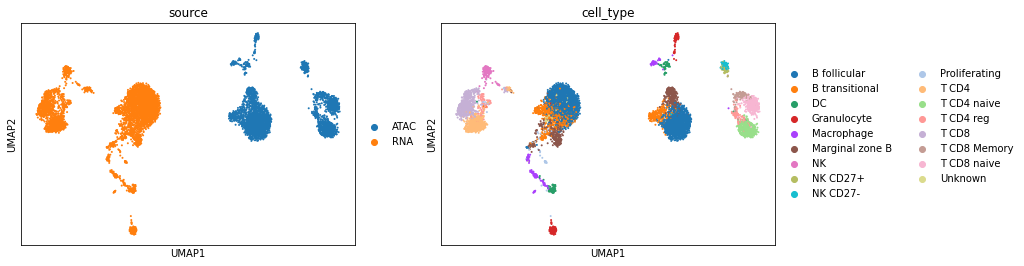

In [11]:
sc.pp.pca(adata_cm)
sc.pp.neighbors(adata_cm)
sc.tl.umap(adata_cm)
sc.pl.umap(adata_cm, color=['source', 'cell_type'])

**After integration.** The output is an AnnData object with the uniport embedding stored in `.obsm['latent']`. Visualize the latent data using UMAP according to their cell types and sources.

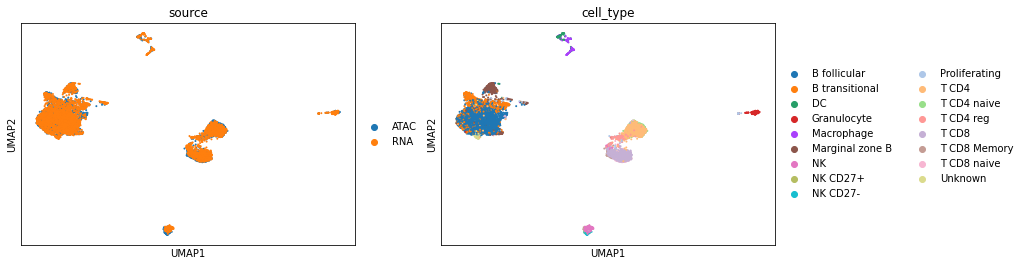

In [12]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata, min_dist=0.1)
sc.pl.umap(adata, color=['source', 'cell_type'])